In [1]:
from regain.datasets.hmm import generate_hmm
from regain.hmm.hmm_graphical_lasso import HMM_GraphicalLasso 
import numpy as np
from importlib import reload
import regain.hmm.utils; reload(regain.hmm.utils)
from regain.hmm.utils import results_recap,prepare_data_to_predict,cov2corr
from regain.hmm.utils import cross_validation,spread_pred_interpretation
import pickle as pkl
#from notebooks.hmm.pred_func import pred_lgb, pred_LSTM, pred_VAR_VARMA, pred_Kernel_Ridge,pred_HMM_GMM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def corr_plot(corrs,covcorr = False):
    
    if covcorr:
        correlations = []
        for k in range(len(corrs)):
            correlations.append(cov2corr(corrs[k]))
        corrs = correlations
        
    N_plots = len(corrs)

    N_per_rows = 3
    N_rows = int(np.ceil(N_plots/N_per_rows))
    f, axes = plt.subplots(N_rows, N_per_rows, figsize=(15, 10))

    count = 0
    for i in range(N_rows):
        for j in range(N_per_rows): 
            if N_rows==1:
                sns.heatmap(corrs[count],  ax=axes[j])            
            else:
                sns.heatmap(corrs[count],  ax=axes[i, j])
            count+=1
            if count == N_plots:
                break
    plt.show()

In [3]:
N_samples = 1000
N_states = 10
N_TS = 10
sigma_Normal = 1

dataset = generate_hmm(n_samples= N_samples,
                       n_states=N_states,
                       n_dim_obs=N_TS,
                       mode_precisions='regain_random',
                       mode_mean = 'Normal',
                       transition_type='fixed',
                       sigma=sigma_Normal)

In [24]:
lam = 15
max_iter = 300

mdl = HMM_GraphicalLasso(alpha=lam,
                         n_clusters=N_states,
                         verbose=False,
                         max_iter=max_iter,
                         mode='scaled',
                         warm_restart=True,
                         repetitions=5,
                         n_jobs=-1)
mdl.fit(dataset['data'])

HMM_GraphicalLasso(alpha=15, init_params={}, max_iter=300, mode='scaled',
                   n_clusters=10, n_jobs=-1, repetitions=5, tol=0.0001,
                   verbose=False, warm_restart=True)

In [25]:
res_batch = results_recap(dataset['states'], mdl.labels_, dataset['thetas'], mdl.precisions_, 
              dataset['gammas'], mdl.gammas_) 
print(res_batch)

{'homogeneity [0, 1]': 0.8261131842475912, 'completeness [0, 1]': 0.8718072532283985, 'v_measure [0, 1]': 0.8483453642683925, 'adjusted_mutual_info [0, 1]': 0.8455876109962643, 'weighted_mean_mcc [-1, 1]': (0.3526102669527341,), 'max_cluster_mean_mcc[-1,1]': (0.37719835805669094,), 'weighted_mean_f1 [0, 1]': (0.4100702454694159,), 'max_cluster_mean_f1[0,1]': (0.4147379736785363,), 'probabilities_clusters': (array([[0.        , 0.        , 0.02857143, 0.01086957, 0.95798319,
        0.        , 0.00990099, 0.        , 0.        , 0.02105263],
       [0.01388889, 0.00740741, 0.        , 0.35326087, 0.        ,
        0.        , 0.04950495, 0.        , 0.        , 0.        ],
       [0.        , 0.99259259, 0.01428571, 0.        , 0.00840336,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.92857143, 0.        , 0.        ,
        0.01639344, 0.01980198, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [26]:
mdl.lambdas

array([ 0.21191089,  0.11086391,  0.21264469,  0.08177476,  0.12501091,
        0.248176  ,  0.14701142,  0.09172825, 15.        ,  0.16137063])

In [ ]:
res = cross_validation(mdl,
       dataset['data'],
       params={'alpha':np.linspace(5,13 ,10),
               'n_clusters':[10]},
       n_repetitions=5)

  0%|          | 0/1 [00:00<?, ?it/s]

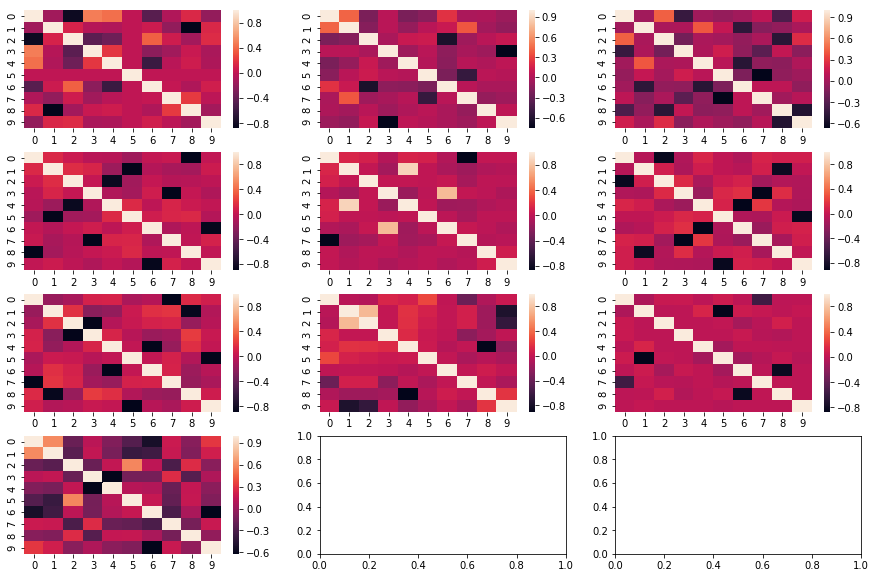

In [22]:
corr_plot(mdl.covariances_,covcorr = True)

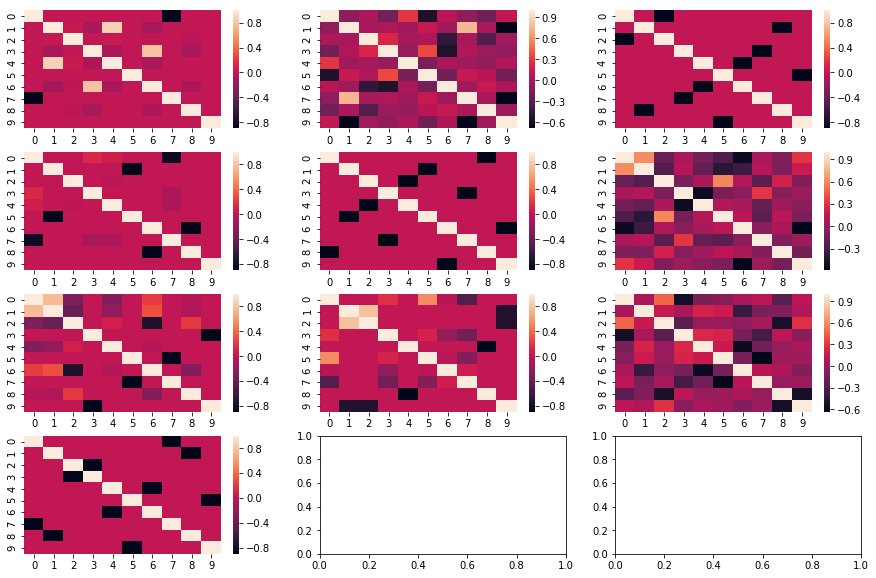

In [23]:
corr_plot(dataset['correlations'])

In [41]:
clusters_list = [N_states]
alpha_list = np.linspace(15, 25, 15)
lam = 3.593813663804626
max_iter = 200

mdl = HMM_GraphicalLasso(alpha=lam,
                         n_clusters=N_states,
                         verbose=False,
                         max_iter=max_iter,
                         mode='scaled',
                         warm_restart=True,
                         repetitions=5,
                         n_jobs=-1)

res = cross_validation(mdl,
                       dataset['data'],
                       params={'alpha':alpha_list,
                               'n_clusters':clusters_list},
                       mode='bic',
                       n_repetitions=1)

100%|██████████| 15/15 [01:26<00:00,  5.76s/it]


In [42]:
res

((25.0, 10),
 {(15.0, 10): {'bics': [35343.65477269161],
   'mean_bic': 35343.65477269161,
   'std_bic': 0.0,
   'connectivity_matrix': array([[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 0., ..., 0., 0., 0.],
          [0., 0., 1., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 1., 1., 0.],
          [0., 0., 0., ..., 1., 1., 0.],
          [0., 0., 0., ..., 0., 0., 1.]]),
   'dispersion_coefficient': 1.1451053827160491,
   'estimators': [HMM_GraphicalLasso(alpha=15.0, init_params={}, max_iter=200, mode='scaled',
                       n_clusters=10, n_jobs=-1, repetitions=5, tol=0.0001,
                       verbose=False, warm_restart=True)]},
  (15.714285714285714, 10): {'bics': [35283.73748883275],
   'mean_bic': 35283.73748883275,
   'std_bic': 0.0,
   'connectivity_matrix': array([[1., 1., 0., ..., 0., 0., 0.],
          [1., 1., 0., ..., 0., 0., 0.],
          [0., 0., 1., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 1., 1., 0.],
          [0

In [5]:
alpha_list = np.linspace(1, 40, 15)

In [6]:
alpha_list

array([ 1.        ,  3.78571429,  6.57142857,  9.35714286, 12.14285714,
       14.92857143, 17.71428571, 20.5       , 23.28571429, 26.07142857,
       28.85714286, 31.64285714, 34.42857143, 37.21428571, 40.        ])

In [7]:
from regain.hmm.incremental_hmm_graphical_lasso import Incremental_HMM_GraphicalLasso as IncHMM
init_params = {'clustering':'gmm', 'probabilities':'random_uniform'}
#perc_increm = 0.1
lambda_GL = 30
toll = 1e-4
max_iterations = 200
reps = 5

lists_perc_increm =[0.01,0.025,0.05,0.075,0.1,0.125, 0.15,0.2,0.25,0.3]# [0.025,0.05,0.075,0.1,0.125, 0.15]#,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
v_meas_res = []
mcc_res= []
lam_mem = []

for perc_increm in lists_perc_increm:

    mdl_Inc = IncHMM(n_clusters=N_states,
                 alpha=lambda_GL,
                 n_for_init=int(N_samples*(1-perc_increm)),
                 max_iter=max_iterations,
                 tol=toll,
                 #init_params = init_params,
                 verbose=False,
                 warm_restart=True,
                 repetitions=reps,
                 n_jobs=-1)
    mdl_Inc.fit(dataset['data'])
    lam_mem.append(mdl_Inc.lambdas)
    res_increm = results_recap(dataset['states'], mdl_Inc.labels_, dataset['thetas'], mdl_Inc.precisions_, 
                  dataset['gammas'], mdl_Inc.gammas_)
    v_meas_res.append(res_increm['v_measure [0, 1]'])
    mcc_res.append(res_increm['weighted_mean_mcc [-1, 1]'][0])

/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(c

In [15]:
print(mcc_res)

[(0.5777742693643927,), (0.479092144765698,), (0.26179247311641857,), (0.4829226363867948,), (0.46767310527539835,)]


In [14]:
print(v_meas_res)

[0.8923866732964255, 0.8635856180532978, 0.8072036212044827, 0.7722228889348347, 0.7458461945161785]


In [9]:
print(lam_mem)

[array([0.19823597, 0.11286285, 0.12857236, 0.28206312, 0.123373  ]), array([0.12675599, 0.12421914, 0.19799463, 0.11353725, 0.28284172]), array([0.10033442, 0.15042742, 0.20402979, 0.16349725, 0.17539601])]


In [17]:
res_batch['v_measure [0, 1]']

0.9151741407171804

In [19]:
res_batch['weighted_mean_mcc [-1, 1]'][0]

0.8060296098780511

In [21]:
mcc_res/res_batch['weighted_mean_mcc [-1, 1]'][0]

array([[0.71681519],
       [0.59438529],
       [0.32479263],
       [0.59913759],
       [0.58021827]])

In [22]:
v_meas_res/res_batch['v_measure [0, 1]']

array([0.9751004 , 0.94362983, 0.88202189, 0.84379885, 0.81497735])

In [9]:
perc_batch = [1-perc for perc in lists_perc_increm]

Text(0, 0.5, '(V_measure_(batch+incremental))/V_measure_all_batch')

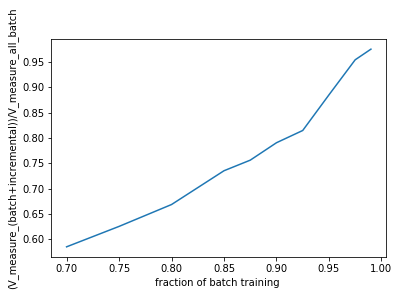

In [13]:
plt.plot(perc_batch,v_meas_res/res_batch['v_measure [0, 1]'])
plt.xlabel('fraction of batch training ')
plt.ylabel('(V_measure_(batch+incremental))/V_measure_all_batch')

Text(0, 0.5, '(MCC_(batch+incremental))/MCC_all_batch')

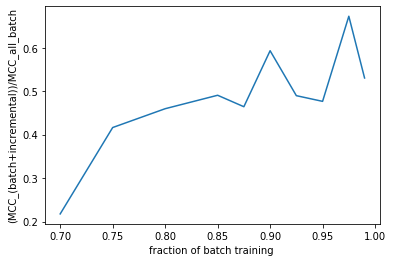

In [12]:
plt.plot(perc_batch,mcc_res/res_batch['weighted_mean_mcc [-1, 1]'][0])
plt.xlabel('fraction of batch training ')
plt.ylabel('(MCC_(batch+incremental))/MCC_all_batch')